# TensorRT Python Inference for yolort

In [1]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

assert torch.cuda.is_available()
device = torch.device('cuda')

print(f"We're using: {device}:{os.environ['CUDA_VISIBLE_DEVICES']}.")

We're using: cuda:0.


In [2]:
import cv2
import numpy as np

from yolort.utils import cv2_imshow
from yolort.utils.image_utils import plot_one_box, color_list
from yolort.v5 import letterbox, non_max_suppression, scale_coords, attempt_download
from yolort.v5.utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages
from yolort.v5.utils.torch_utils import select_device, time_sync

## Prepare image and model weights to test

In [3]:
# Define some parameters
img_size = [320, 320]
stride = 32
score_thresh = 0.35
iou_thresh = 0.45
detections_per_img = 100
half = False

In [4]:
# img_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/main/test/assets/zidane.jpg"
img_source = "https://gitee.com/zhiqwang/yolov5-rt-stack/raw/main/test/assets/zidane.jpg"
dataset = LoadImages(img_source, img_size=img_size, stride=stride, auto=False)

# yolov5s6.pt is downloaded from 'https://github.com/ultralytics/yolov5/releases/download/v6.0/yolov5n6.pt'
model_path = "https://github.com/ultralytics/yolov5/releases/download/v6.0/yolov5n6.pt"
checkpoint_path = attempt_download(model_path)
onnx_path = "yolov5n6.onnx"
engine_path = "yolov5n6.engine"

In [5]:
path, image, img_raw, _, s = next(iter(dataset))

## Export to ONNX and TensorRT model

Define the YOLOTRTModule for TensorRT inferencing.

In [6]:
from yolort.runtime.yolo_graphsurgeon import YOLOGraphSurgeon

In [7]:
yolo_gs = YOLOGraphSurgeon(
    model_path,
    version="r6.0",
    enable_dynamic=False,
)


                 from  n    params  module                                  arguments                     
  0                -1  1      1760  yolort.v5.models.common.Conv            [3, 16, 6, 2, 2]              
  1                -1  1      4672  yolort.v5.models.common.Conv            [16, 32, 3, 2]                
  2                -1  1      4800  yolort.v5.models.common.C3              [32, 32, 1]                   
  3                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  4                -1  2     29184  yolort.v5.models.common.C3              [64, 64, 2]                   
  5                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  6                -1  3    156928  yolort.v5.models.common.C3              [128, 128, 3]                 
  7                -1  1    221568  yolort.v5.models.common.Conv            [128, 192, 3, 2]              
  8                -1  1    167040  

[W] 'Shape tensor cast elision' routine failed with: None


In [8]:
yolo_gs.register_nms(
    score_thresh=score_thresh,
    nms_thresh=iou_thresh,
    detections_per_img=detections_per_img,
)

Created NMS plugin 'BatchedNMS_TRT' with attributes: {'plugin_version': '1', 'shareLocation': True, 'backgroundLabelId': -1, 'numClasses': 80, 'topK': 1024, 'keepTopK': 100, 'scoreThreshold': 0.35, 'iouThreshold': 0.45, 'isNormalized': True, 'clipBoxes': False}


In [9]:
yolo_gs.save(onnx_path)

Saved ONNX model to yolov5n6.onnx


### Build and export the TensorRT engine.

In [10]:
from yolort.runtime.trt_helper import EngineBuilder

In [11]:
engine_builder = EngineBuilder()

[12/25/2021-03:19:38] [TRT] [I] [MemUsageChange] Init CUDA: CPU +177, GPU +0, now: CPU 370, GPU 4652 (MiB)


In [12]:
engine_builder.create_network(onnx_path)

Network Description
Input 'images' with shape (1, 3, 320, 320) and dtype DataType.FLOAT
Output 'num_detections' with shape (1,) and dtype DataType.INT32
Output 'detection_boxes' with shape (1, 100, 4) and dtype DataType.FLOAT
Output 'detection_scores' with shape (1, 100) and dtype DataType.FLOAT
Output 'detection_classes' with shape (1, 100) and dtype DataType.FLOAT


[12/25/2021-03:19:38] [TRT] [I] ----------------------------------------------------------------
[12/25/2021-03:19:38] [TRT] [I] Input filename:   yolov5n6.onnx
[12/25/2021-03:19:38] [TRT] [I] ONNX IR version:  0.0.8
[12/25/2021-03:19:38] [TRT] [I] Opset version:    11
[12/25/2021-03:19:38] [TRT] [I] Producer name:    
[12/25/2021-03:19:38] [TRT] [I] Producer version: 
[12/25/2021-03:19:38] [TRT] [I] Domain:           
[12/25/2021-03:19:38] [TRT] [I] Model version:    0
[12/25/2021-03:19:38] [TRT] [I] Doc string:       
[12/25/2021-03:19:38] [TRT] [I] ----------------------------------------------------------------
[12/25/2021-03:19:38] [TRT] [W] parsers/onnx/onnx2trt_utils.cpp:364: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[12/25/2021-03:19:38] [TRT] [W] parsers/onnx/onnx2trt_utils.cpp:392: One or more weights outside the range of INT32 was clamped
[12/25/2021-03:19:38] [TRT] [W] parsers/onn

In [13]:
engine_builder.create_engine(engine_path, precision="fp32")

Building fp32 Engine in yolov5n6.engine
Using fp32 mode.


[12/25/2021-03:19:38] [TRT] [I] [MemUsageSnapshot] Builder begin: CPU 441 MiB, GPU 4652 MiB
[12/25/2021-03:19:40] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.6.1 but loaded cuBLAS/cuBLAS LT 11.5.1
[12/25/2021-03:19:40] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +232, GPU +94, now: CPU 676, GPU 4746 (MiB)
[12/25/2021-03:19:40] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +188, GPU +84, now: CPU 864, GPU 4830 (MiB)
[12/25/2021-03:19:40] [TRT] [I] Local timing cache in use. Profiling results in this builder pass will not be stored.
[12/25/2021-03:20:23] [TRT] [I] [BlockAssignment] Algorithm Linear took 0.05512ms to assign 158 blocks to 158 nodes requiring 4327119366 bytes.
[12/25/2021-03:20:23] [TRT] [I] Total Activation Memory: 32152070
[12/25/2021-03:20:23] [TRT] [I] Detected 1 inputs and 4 output network tensors.


Serialize engine success, saved as yolov5n6.engine


[12/25/2021-03:20:29] [TRT] [I] Total Host Persistent Memory: 168176
[12/25/2021-03:20:29] [TRT] [I] Total Device Persistent Memory: 5879296
[12/25/2021-03:20:29] [TRT] [I] Total Scratch Memory: 12998656
[12/25/2021-03:20:29] [TRT] [I] [MemUsageStats] Peak memory usage of TRT CPU/GPU memory allocators: CPU 3 MiB, GPU 535 MiB
[12/25/2021-03:20:29] [TRT] [I] [BlockAssignment] Algorithm ShiftNTopDown took 33.9313ms to assign 8 blocks to 159 nodes requiring 17336832 bytes.
[12/25/2021-03:20:29] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.6.1 but loaded cuBLAS/cuBLAS LT 11.5.1
[12/25/2021-03:20:29] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 2758, GPU 5710 (MiB)
[12/25/2021-03:20:29] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 2758, GPU 5718 (MiB)
[12/25/2021-03:20:29] [TRT] [I] [MemUsageSnapshot] Builder end: CPU 2757 MiB, GPU 5684 MiB


## Test the exported TensorRT engine

Let's load the TensorRT engine firstly.

In [14]:
from yolort.runtime import PredictorTRT

In [15]:
engine = PredictorTRT(engine_path, device)

Loading yolov5n6.engine for TensorRT inference...


[12/25/2021-03:20:29] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.

[12/25/2021-03:20:29] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 2743, GPU 5668 (MiB)
[12/25/2021-03:20:29] [TRT] [I] Loaded engine size: 14 MiB
[12/25/2021-03:20:29] [TRT] [I] [MemUsageSnapshot] deserializeCudaEngine begin: CPU 2758 MiB, GPU 5668 MiB
[12/25/2021-03:20:29] [TRT] [W] TensorRT was linked against cuBLAS/cuBLAS LT 11.6.1 but loaded cuBLAS/cuBLAS LT 11.5.1
[12/25/2021-03:20:29] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +10, now: CPU 2770, GPU 5692 (MiB)
[12/25/2021-03:20:29] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 2770, GPU 5700 (MiB)
[12/25/2021-03:20:29] [TRT] [I] [MemUsageSnapshot] deserializeCudaEngine end: CPU 2770 MiB, GPU 5682 MiB
[12/25/2021-03:20:29] [TRT] [

In [16]:
engine.warmup(img_size=(1, 3, *img_size), half=half)

### Pre Processing

In [17]:
time_start = time_sync()
image = engine.preprocessing(image)
time_consumed = time_sync() - time_start
print(f"pre-process: {time_consumed * 1000:.3f}ms")

pre-process: 0.865ms


### Inferencing

In [18]:
time_start = time_sync()
tensorrt_outs = engine.run_on_image(image)
time_consumed = time_sync() - time_start
print(f"inference: {time_consumed * 1000:.3f}ms")

inference: 3.713ms


## Predict as yolort

In [19]:
from yolort.models import YOLO

In [20]:
model = YOLO.load_from_yolov5(
    checkpoint_path,
    score_thresh=score_thresh,
    nms_thresh=iou_thresh,
    version="r6.0",
)

model = model.to(device)
model = model.eval()


                 from  n    params  module                                  arguments                     
  0                -1  1      1760  yolort.v5.models.common.Conv            [3, 16, 6, 2, 2]              
  1                -1  1      4672  yolort.v5.models.common.Conv            [16, 32, 3, 2]                
  2                -1  1      4800  yolort.v5.models.common.C3              [32, 32, 1]                   
  3                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  4                -1  2     29184  yolort.v5.models.common.C3              [64, 64, 2]                   
  5                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  6                -1  3    156928  yolort.v5.models.common.C3              [128, 128, 3]                 
  7                -1  1    221568  yolort.v5.models.common.Conv            [128, 192, 3, 2]              
  8                -1  1    167040  

In [21]:
with torch.no_grad():
    yolort_outs = model(image)

## Varify the detection results between yolort and TensorRT

In [22]:
# Testing boxes
torch.testing.assert_close(yolort_outs[0]["boxes"], tensorrt_outs[0]["boxes"])
# Testing scores
torch.testing.assert_close(yolort_outs[0]["scores"], tensorrt_outs[0]["scores"])
# Testing labels
torch.testing.assert_close(yolort_outs[0]["labels"], tensorrt_outs[0]["labels"].to(dtype=torch.int64))

print("Exported model has been tested, and the result looks good!")

Exported model has been tested, and the result looks good!


## Visualise the TensorRT detections

Hah, that's the trick to rescale the box correctly

In [23]:
boxes = scale_coords(image.shape[2:], tensorrt_outs[0]['boxes'], img_raw.shape[:-1])
labels = tensorrt_outs[0]['labels']

In [24]:
# Get label names
import requests

# label_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/main/notebooks/assets/coco.names"
label_path = "https://gitee.com/zhiqwang/yolov5-rt-stack/raw/main/notebooks/assets/coco.names"
response = requests.get(label_path)
names = response.text

LABELS = []

for label in names.strip().split('\n'):
    LABELS.append(label)

COLORS = color_list()

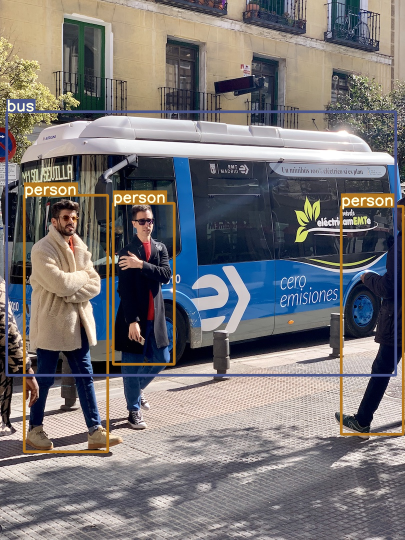

In [25]:
for box, label in zip(boxes.tolist(), labels.to(dtype=torch.int64).tolist()):
    img_raw = plot_one_box(box, img_raw, color=COLORS[label % len(COLORS)], label=LABELS[label])

cv2_imshow(img_raw, imshow_scale=0.5)